<a href="https://colab.research.google.com/github/joshtburdick/misc/blob/master/plog/Classifying_digits_using_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifying digits using clustering
This is an attempt at using multivariate-normal soft clustering to model and classify digits. It's inspired by Gaussian Processes, and soft clustering.

It's based on:
- https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html (for basic Jax info, and loading MNIST)




In [27]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn
import matplotlib.pyplot as plt

In [4]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [5]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /tmp/tfds/mnist/incomplete.YDWEBQ_3.0.1/mnist-train.tfrecord*...:   0%|          | 0/60000 [00:00<?,…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /tmp/tfds/mnist/incomplete.YDWEBQ_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/10000 [00:00<?, …

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


We plot some digits as examples.

<Figure size 1500x300 with 0 Axes>

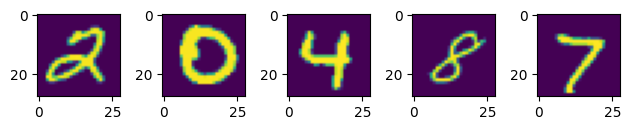

In [7]:
x = test_images.reshape([-1,28,28])
plt.figure(figsize=(15,3))
fig, axs = plt.subplots(1, 5)
for i in range(5):
  axs[i].imshow(x[i,:,:])
fig.tight_layout()
plt.show()

### Converting to "long" form

We will need to convert things to "long" form (Tidyverse-style). Thus, we construct a vector of the coordinates of each points.

In [8]:
# Deprecated; doesn't seem neccessary.
def grid_points(n):
  """Constructs an array of 2-D points in a grid.

  n: the number of points
  Returns: an array with two columns, being the x and y coordinates,
    (in the range [0, 1))
  """
  # this is not super-efficient
  x = jnp.array([list(range(n))] * n)
  return jnp.stack([
      x.flatten(),
      x.T.flatten()
  ])

### 2-D normal density on a grid

We'll need a normal density defined over the grid points.

In [9]:
# prompt: given the mean and covariance of a 2-dimensional normal vector, compute its density in a square grid of n points, numbering from 0..n-1 .

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# ... (rest of the provided code)

def normal_density_2d_grid(mu, si2, n):
  """
  Computes the density of a 2D normal distribution on a grid.

  Args:
    mu: array of shape (2,), giving the mean.
    si2: array of shape (2, 2), giving the covariance matrix.
    n: Number of points along each dimension of the grid.

  Returns:
    A 2D array of shape (n, n) representing the density values on the grid.
  """
  x = jnp.linspace(0, n - 1, n)
  X, Y = jnp.meshgrid(x, x)
  pos = jnp.dstack((X, Y))

  # Calculate the density using the multivariate normal probability density function
  diff = pos - mu
  exponent = -0.5 * jnp.sum(diff @ jnp.linalg.inv(si2) * diff, axis=2)
  density = jnp.exp(exponent) / (2 * jnp.pi * jnp.sqrt(jnp.linalg.det(si2)))
  return density


In [10]:
mvnorm_density = normal_density_2d_grid(jnp.array([5,5]), jnp.array([[10,-8],[-8,10]]), 16)

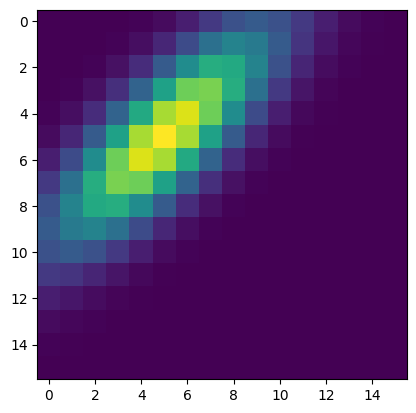

In [11]:
plt.imshow(mvnorm_density)

This is what I got, when I tried to explain this. (I don't think I explained it very well.)

In [12]:
def shape_representation(points, means, covariances):
  """
  Represents the shape of a digit using a mixture of multivariate normal distributions.

  Args:
    points: An array of shape (N, 2) representing the coordinates of the points.
    means: An array of shape (k, 2) representing the means of the k distributions.
    covariances: An array of shape (k, 2, 2) representing the covariance matrices of the k distributions.

  Returns:
    An array of shape (N, k) representing the probability density of each point under each distribution.
  """
  # This is a placeholder and needs to be implemented based on the specific
  # mixture model and classification approach (e.g., soft clustering, nearest center).
  # For a simple nearest center approach, you might calculate the distance
  # from each point to each mean and assign to the closest.
  # For a soft clustering approach, you would calculate the probability density
  # of each point under each multivariate normal distribution.

  # Example (soft clustering):
  k = means.shape[0]
  n = points.shape[0]
  density = jnp.zeros((n, k))

  for i in range(k):
    mu = means[i]
    si2 = covariances[i]
    diff = points - mu
    exponent = -0.5 * jnp.sum(diff @ jnp.linalg.inv(si2) * diff, axis=1)
    density = density.at[:, i].set(jnp.exp(exponent) / (2 * jnp.pi * jnp.sqrt(jnp.linalg.det(si2))))

  return density

We'll represent each digit's shape by k 2D MV normal distributions. But we'll be keeping track of the *covariance* between all of them
(kind of as in a Gaussian process). So for each digit, we'll have a $2k$-dimensional MV normal distribution.

Breaking this down some:

In [13]:
def pixel_likelihoods(image, means, covariances, image_shape=(28, 28)):
    """
    Calculates the likelihood of each pixel in an image originating from each of k 2D MV normal distributions.

    Args:
      image: A flattened array of shape (num_pixels,) representing the image.
      means: An array of shape (k, 2) representing the means of the k distributions.
      covariances: An array of shape (k, 2, 2) representing the covariance matrices of the k distributions.
      image_shape: A tuple (height, width) representing the original shape of the image.

    Returns:
      An array of shape (num_pixels, k) representing the likelihood of each pixel under each distribution.
    """
    num_pixels = image.shape[0]
    k = means.shape[0]
    likelihoods = jnp.zeros((num_pixels, k))

    # Create a grid of pixel coordinates
    height, width = image_shape
    x = jnp.linspace(0, width - 1, width)
    y = jnp.linspace(0, height - 1, height)
    X, Y = jnp.meshgrid(x, y)
    points = jnp.dstack((X, Y)).reshape(-1, 2)

    for i in range(k):
        mu = means[i]
        si2 = covariances[i]
        diff = points - mu
        # Calculate the exponent term of the multivariate normal PDF
        # We need to handle potential singular covariance matrices, add a small epsilon for numerical stability
        si2_inv = jnp.linalg.inv(si2 + jnp.eye(2) * 1e-6)
        exponent = -0.5 * jnp.sum((diff @ si2_inv) * diff, axis=1)

        # Calculate the density and scale by the pixel intensity
        density = jnp.exp(exponent) / (2 * jnp.pi * jnp.sqrt(jnp.linalg.det(si2 + jnp.eye(2) * 1e-6)))
        likelihoods = likelihoods.at[:, i].set(density * image)

    return likelihoods

In [16]:
# Select a test image (e.g., the first one)
test_image = test_images[0]

# Normalize pixel intensities to [0, 1]
test_image_normalized = test_image / 255.0

# Define the number of distributions (k)
k = 5

# Create random means and covariances for k distributions
key = random.PRNGKey(0)
means_key, cov_key = random.split(key)

# Random means within the image dimensions
means = random.uniform(means_key, (k, 2), minval=0, maxval=27)

# Random covariances (ensure they are positive semi-definite)
# A simple way is to generate random matrices and make them symmetric and add a diagonal for stability
random_cov_matrices = random.normal(cov_key, (k, 2, 2))
covariances = jnp.matmul(random_cov_matrices, jnp.transpose(random_cov_matrices, (0, 2, 1))) + jnp.eye(2) * 1e-3

# Calculate the pixel likelihoods
pixel_lik = pixel_likelihoods(test_image_normalized, means, covariances)

print("Shape of pixel likelihoods:", pixel_lik.shape)

Shape of pixel likelihoods: (784, 5)


Now let's visualize the likelihoods for each distribution.

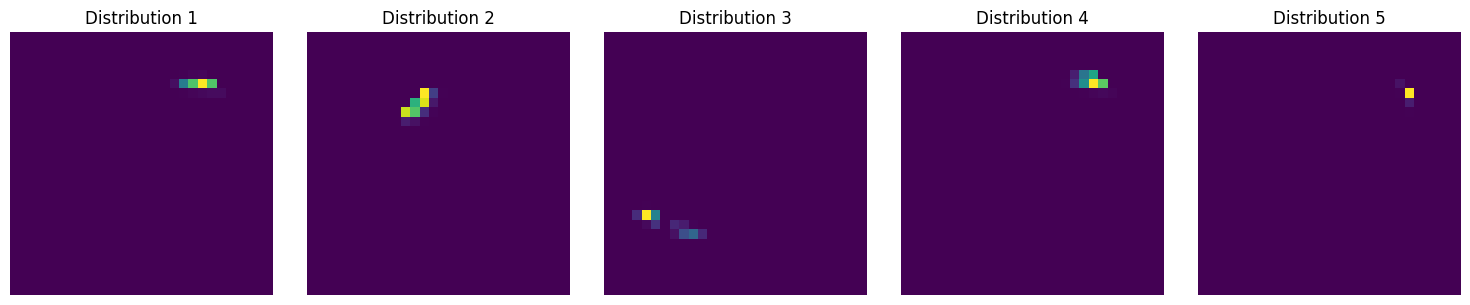

In [17]:
fig, axes = plt.subplots(1, k, figsize=(15, 3))

for i in range(k):
    likelihood_image = pixel_lik[:, i].reshape(28, 28)
    axes[i].imshow(likelihood_image, cmap='viridis')
    axes[i].set_title(f'Distribution {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

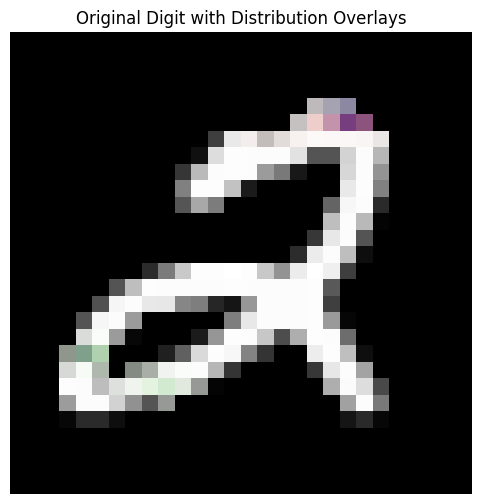

In [18]:
# Reshape the test image back to 28x28 for plotting
original_image = test_image_normalized.reshape(28, 28)

# Create an RGB image to overlay the distributions
# Start with the original image as a grayscale background (converted to RGB)
# We can use a colormap like 'gray'
original_image_rgb = plt.cm.gray(original_image)[:,:,:3] # Take only the RGB channels

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Display the original image
ax.imshow(original_image, cmap='gray')

# Overlay each distribution's likelihoods
# We will use different colormaps for each distribution and adjust alpha for transparency
cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges'] # Colormaps for k distributions

for i in range(k):
    likelihood_image = pixel_lik[:, i].reshape(28, 28)
    # Use a colormap to color the likelihoods and set alpha for transparency
    # Only apply the colormap where the likelihood is significant
    masked_likelihood = jnp.where(likelihood_image > 1e-5, likelihood_image, jnp.nan) # Mask low likelihoods

    ax.imshow(masked_likelihood, cmap=cmaps[i], alpha=0.5) # Adjust alpha as needed

ax.set_title('Original Digit with Distribution Overlays')
ax.axis('off')
plt.show()

# Task
Implement a model that represents a shape as a mixture of k 2-D MV normal distributions, where these k distributions are derived from a single 2k-dimensional multivariate normal distribution. The model should take an MNIST digit (normalized to [0,1]) as input and return the likelihood of each pixel belonging to each of the k 2-D distributions. Train this model using JAX to classify MNIST digits and evaluate its performance.

## Define the 2k-dimensional mv normal

### Subtask:
Define the parameters (mean vector and covariance matrix) for a single 2k-dimensional multivariate normal distribution.


**Reasoning**:
Define the parameters for the 2k-dimensional multivariate normal distribution based on the instructions.



In [20]:
# Determine the total dimension
total_dim = 2 * k

# Initialize the mean vector (2k)
# Initialize with zeros
mean_2k = jnp.zeros(total_dim)

# Initialize the covariance matrix (2k, 2k)
# Start with an identity matrix scaled by a small value for stability
cov_2k = jnp.eye(total_dim) * 1e-2

# Add some small random symmetric noise (optional, but can help break symmetry)
# Ensure the resulting matrix is symmetric and positive semi-definite
key, subkey = random.split(key)
random_noise = random.normal(subkey, (total_dim, total_dim))
random_noise = (random_noise + random_noise.T) * 1e-4 # Make it symmetric and small
cov_2k = cov_2k + random_noise

# Ensure positive semi-definite by adding a diagonal term if needed (though starting with eye * small_value helps)
# Another way is to use the form A @ A.T + epsilon * I
key, subkey = random.split(key)
A = random.normal(subkey, (total_dim, total_dim)) * 1e-2
cov_2k = jnp.matmul(A, A.T) + jnp.eye(total_dim) * 1e-3


print("Shape of 2k-dimensional mean vector:", mean_2k.shape)
print("Shape of 2k-dimensional covariance matrix:", cov_2k.shape)

Shape of 2k-dimensional mean vector: (10,)
Shape of 2k-dimensional covariance matrix: (10, 10)


## Derive parameters for k 2d mv normals

### Subtask:
Create a function to extract the means and covariance matrices for the k individual 2D MV normal distributions from the parameters of the 2k-dimensional distribution. The 2k-dimensional covariance matrix will define the relationships between the k 2D distributions.


**Reasoning**:
Define the function to extract the k 2D means and covariance matrices from the 2k-dimensional parameters.



In [21]:
def extract_2d_params(mean_2k, cov_2k, k):
  """
  Extracts the means and covariance matrices for k 2D normal distributions
  from the parameters of a single 2k-dimensional normal distribution.

  Args:
    mean_2k: A JAX array of shape (2k,) representing the mean of the 2k-dim distribution.
    cov_2k: A JAX array of shape (2k, 2k) representing the covariance matrix
            of the 2k-dim distribution.
    k: The number of 2D distributions.

  Returns:
    A tuple containing:
      - means_2d: A JAX array of shape (k, 2) representing the means of the k 2D distributions.
      - covariances_2d: A JAX array of shape (k, 2, 2) representing the covariance
                        matrices of the k 2D distributions.
  """
  # Extract the k 2D mean vectors by splitting the 2k-dimensional mean vector
  means_2d = mean_2k.reshape(k, 2)

  # Extract the k 2D covariance matrices by taking 2x2 slices
  covariances_2d = jnp.zeros((k, 2, 2))
  for i in range(k):
    covariances_2d = covariances_2d.at[i].set(cov_2k[2*i : 2*i+2, 2*i : 2*i+2])

  return means_2d, covariances_2d

# Example usage with the previously defined mean_2k and cov_2k
extracted_means, extracted_covariances = extract_2d_params(mean_2k, cov_2k, k)

print("Shape of extracted 2D means:", extracted_means.shape)
print("Shape of extracted 2D covariances:", extracted_covariances.shape)

Shape of extracted 2D means: (5, 2)
Shape of extracted 2D covariances: (5, 2, 2)


## Update `pixel likelihoods`

### Subtask:
Modify the `pixel_likelihoods` function to take the parameters of the 2k-dimensional MV normal as input, derive the parameters for the k 2D distributions using the function from step 2, and then calculate the pixel likelihoods as before.


**Reasoning**:
Modify the pixel_likelihoods function as instructed, then test it with the 2k-dimensional parameters and print the shape of the output.



In [22]:
def pixel_likelihoods(image, mean_2k, cov_2k, image_shape=(28, 28)):
    """
    Calculates the likelihood of each pixel in an image originating from each of k 2D MV normal distributions,
    derived from a single 2k-dimensional MV normal distribution.

    Args:
      image: A flattened array of shape (num_pixels,) representing the image.
      mean_2k: A JAX array of shape (2k,) representing the mean of the 2k-dim distribution.
      cov_2k: A JAX array of shape (2k, 2k) representing the covariance matrix
              of the 2k-dim distribution.
      image_shape: A tuple (height, width) representing the original shape of the image.

    Returns:
      An array of shape (num_pixels, k) representing the likelihood of each pixel under each distribution.
    """
    # Determine k from the shape of the 2k-dimensional mean
    k = mean_2k.shape[0] // 2

    # Extract the k 2D means and covariances using the helper function
    means, covariances = extract_2d_params(mean_2k, cov_2k, k)

    num_pixels = image.shape[0]
    likelihoods = jnp.zeros((num_pixels, k))

    # Create a grid of pixel coordinates
    height, width = image_shape
    x = jnp.linspace(0, width - 1, width)
    y = jnp.linspace(0, height - 1, height)
    X, Y = jnp.meshgrid(x, y)
    points = jnp.dstack((X, Y)).reshape(-1, 2)

    for i in range(k):
        mu = means[i]
        si2 = covariances[i]
        diff = points - mu
        # Calculate the exponent term of the multivariate normal PDF
        # We need to handle potential singular covariance matrices, add a small epsilon for numerical stability
        si2_inv = jnp.linalg.inv(si2 + jnp.eye(2) * 1e-6)
        exponent = -0.5 * jnp.sum((diff @ si2_inv) * diff, axis=1)

        # Calculate the density and scale by the pixel intensity
        density = jnp.exp(exponent) / (2 * jnp.pi * jnp.sqrt(jnp.linalg.det(si2 + jnp.eye(2) * 1e-6)))
        likelihoods = likelihoods.at[:, i].set(density * image)

    return likelihoods

# Test the modified function
pixel_lik_modified = pixel_likelihoods(test_image_normalized, mean_2k, cov_2k, image_shape=(28, 28))

print("Shape of pixel likelihoods (modified function):", pixel_lik_modified.shape)

Shape of pixel likelihoods (modified function): (784, 5)


## Define the model's output

### Subtask:
Determine how the output of this model will be used for classification. Since we have likelihoods for each pixel under each of the k distributions (derived from the 2k-dimensional MVN), we need a way to combine this information to produce a classification score for each digit class.


**Reasoning**:
I will implement the `predict` and `batched_predict` functions as described in the instructions. The `predict` function will calculate the likelihood of an image belonging to each digit class by summing the pixel likelihoods for each of the `k` distributions and then summing the results for each class. The `batched_predict` function will use `vmap` to apply this logic to a batch of images.



In [23]:
def predict(params, image):
  """Predict the class of a single image."""
  scores = []
  for mean_2k, cov_2k in params:
    # 1. & 2. Summarize pixel likelihoods and combine for a final score
    pixel_lik = pixel_likelihoods(image, mean_2k, cov_2k)
    score = jnp.sum(pixel_lik)
    scores.append(score)
  return jnp.array(scores)

# 3. Create a batched version of the prediction function
batched_predict = vmap(predict, in_axes=(None, 0))

# Example usage (will be used in training later)
# Initialize dummy parameters for 10 digit classes
# In a real scenario, these would be learned during training
key = random.PRNGKey(42)
num_classes = 10
k = 5 # Number of 2D distributions per class
total_dim = 2 * k
# Create a list of (mean, cov) tuples for each class
dummy_params = []
for _ in range(num_classes):
    key, subkey1, subkey2 = random.split(key, 3)
    mean_2k = random.normal(subkey1, (total_dim,))
    # Ensure covariance is positive semi-definite
    A = random.normal(subkey2, (total_dim, total_dim))
    cov_2k = jnp.matmul(A, A.T) + jnp.eye(total_dim) * 1e-3
    dummy_params.append((mean_2k, cov_2k))


# Predict on a single image
single_prediction_scores = predict(dummy_params, test_image_normalized)
print("Scores for a single image (one for each class):", single_prediction_scores)
print("Predicted class for single image:", jnp.argmax(single_prediction_scores))


# Predict on a batch of images
# Let's take a small batch from the test set
batch_size = 16
image_batch = test_images[:batch_size] / 255.0
batch_prediction_scores = batched_predict(dummy_params, image_batch)
print("\nShape of scores for a batch of images:", batch_prediction_scores.shape)
print("Predicted classes for the batch:", jnp.argmax(batch_prediction_scores, axis=1))

Scores for a single image (one for each class): [1.7459634e-04 7.0525298e-04 1.2217680e-04 4.2716385e-04 3.3630738e-05
 6.7911437e-04 1.2212989e-03 1.2942227e-05 3.3954083e-04 1.0607917e-03]
Predicted class for single image: 6

Shape of scores for a batch of images: (16, 10)
Predicted classes for the batch: [6 6 6 6 6 6 6 6 6 1 6 9 6 6 6 6]


## Define the loss function

### Subtask:
Based on the model's output and the classification goal, define a suitable loss function (e.g., negative log-likelihood of the correct digit class).


**Reasoning**:
Define the loss function based on the negative log-likelihood of the correct digit class, using the predicted scores from `batched_predict`.



In [29]:
import jax.nn

def loss(params, images, targets):
  """
  Calculates the negative log-likelihood loss.

  Args:
    params: A list of (mean_2k, cov_2k) tuples, one for each class.
    images: A batch of flattened images, shape (batch_size, num_pixels).
    targets: A batch of one-hot encoded target labels, shape (batch_size, num_labels).

  Returns:
    The calculated negative log-likelihood loss.
  """
  preds = batched_predict(params, images)

  # Implement negative log-likelihood loss.
  # Since batched_predict returns scores (sum of likelihoods), which are not
  # directly probabilities, we can interpret them as unnormalized log-probabilities
  # or use a loss function that encourages higher scores for the correct class.
  # Given the prompt specifically mentions "negative log-likelihood", let's
  # assume the scores can be treated as unnormalized log-probabilities for now,
  # and use logsumexp for normalization and then the negative log-likelihood.
  # Add a small epsilon to scores before log for numerical stability if needed,
  # or use jnp.logaddexp or jnp.logsumexp directly on the scores.

  # A common approach for unnormalized log-probabilities (logits) is
  # cross-entropy loss, which is equivalent to negative log-likelihood
  # when targets are one-hot encoded.
  # log_softmax(preds) = preds - logsumexp(preds, axis=-1, keepdims=True)
  # negative_log_likelihood = -sum(targets * log_softmax(preds), axis=-1)
  # mean_negative_log_likelihood = mean(-sum(targets * log_softmax(preds), axis=-1))

  # JAX provides jnp.nn.softmax and jnp.nn.log_softmax which are numerically stable.
  # We can also directly compute the negative log-likelihood from scores:
  # log_likelihood = jnp.sum(targets * jnp.log(jnp.nn.softmax(preds)), axis=-1)
  # negative_log_likelihood = -jnp.mean(log_likelihood)

  # Or, more directly using the log-softmax trick:
  log_preds = jnp.log(jax.nn.softmax(preds) + 1e-9) # Add epsilon for stability
  return -jnp.mean(targets * log_preds)

# Example usage (assuming dummy_params, image_batch, test_labels[:batch_size] are available)
# Need to make sure test_labels[:batch_size] is one-hot encoded
target_batch = one_hot(test_data['label'][:batch_size], num_labels)
calculated_loss = loss(dummy_params, image_batch, target_batch)
print("Calculated loss for the batch:", calculated_loss)

Calculated loss for the batch: 0.23041712


**Reasoning**:
The previous code failed because `jnp.nn` does not exist. The `nn` module in JAX is typically accessed via `jax.experimental.nn` or `flax.linen`. Since we are aiming for a basic implementation without external libraries like Flax, we can manually implement the softmax and log functions or use `jax.scipy.special.logsumexp` to compute the log-softmax for numerical stability as described in the instruction's comments. Let's use `jax.scipy.special.logsumexp` to compute the log-softmax.



In [30]:
import jax.scipy.special as jsp

def loss(params, images, targets):
  """
  Calculates the negative log-likelihood loss.

  Args:
    params: A list of (mean_2k, cov_2k) tuples, one for each class.
    images: A batch of flattened images, shape (batch_size, num_pixels).
    targets: A batch of one-hot encoded target labels, shape (batch_size, num_labels).

  Returns:
    The calculated negative log-likelihood loss.
  """
  preds = batched_predict(params, images)

  # Implement negative log-likelihood loss using log-softmax trick for numerical stability.
  # log_softmax(preds) = preds - logsumexp(preds, axis=-1, keepdims=True)
  # negative_log_likelihood = -sum(targets * log_softmax(preds), axis=-1)
  # mean_negative_log_likelihood = mean(-sum(targets * log_softmax(preds), axis=-1))

  log_probs = preds - jsp.logsumexp(preds, axis=-1, keepdims=True)
  return -jnp.mean(targets * log_probs)

# Example usage (assuming dummy_params, image_batch, test_labels[:batch_size] are available)
# Need to make sure test_labels[:batch_size] is one-hot encoded
target_batch = one_hot(test_data['label'][:batch_size], num_labels)
calculated_loss = loss(dummy_params, image_batch, target_batch)
print("Calculated loss for the batch:", calculated_loss)

Calculated loss for the batch: 0.23041709


## Implement the update rule

### Subtask:
Implement the training step using JAX's `grad` and `jit` to optimize the parameters of the 2k-dimensional MV normal distribution based on the loss function.


**Reasoning**:
Implement the update step for the model parameters using JAX's grad and jit to optimize the loss function.



In [32]:
step_size = 1e-3 # Define a learning rate

@jit
def update_step(params, images, targets):
  """
  Performs a single gradient descent update step for the model parameters.

  Args:
    params: A list of (mean_2k, cov_2k) tuples, one for each class.
    images: A batch of flattened images, shape (batch_size, num_pixels).
    targets: A batch of one-hot encoded target labels, shape (batch_size, num_labels).

  Returns:
    A list of updated (mean_2k, cov_2k) tuples.
  """
  # Compute gradients of the loss function with respect to params
  grads = grad(loss)(params, images, targets)

  # Update parameters using gradient descent
  updated_params = []
  for i in range(len(params)):
    mean_2k, cov_2k = params[i]
    dmean_2k, dcov_2k = grads[i]

    # Update mean
    new_mean_2k = mean_2k - step_size * dmean_2k

    # Update covariance matrix
    # Simple gradient descent on the covariance matrix might not maintain
    # positive semi-definiteness. A common approach is to update a lower
    # triangular matrix L such that Cov = L @ L.T.
    # For this implementation, let's apply gradient descent directly and
    # rely on later steps or a projection to maintain positive semi-definiteness
    # if needed. This is a simplification for this subtask.
    new_cov_2k = cov_2k - step_size * dcov_2k

    updated_params.append((new_mean_2k, new_cov_2k))

  return updated_params

# Example usage (assuming dummy_params, image_batch, target_batch are available)
updated_dummy_params = update_step(dummy_params, image_batch, target_batch)

# Check the shapes of the updated parameters
print("Shape of updated mean for class 0:", updated_dummy_params[0][0].shape)
print("Shape of updated covariance for class 0:", updated_dummy_params[0][1].shape)

# Calculate loss after one update step
loss_after_update = loss(updated_dummy_params, image_batch, target_batch)
print("Loss after one update step:", loss_after_update)

Shape of updated mean for class 0: (10,)
Shape of updated covariance for class 0: (10, 10)
Loss after one update step: 0.23041709
